<a href="https://colab.research.google.com/github/raulbenitez/postgrau_IML_exploratory/blob/master/RECOMENDADORES/Recomendadores_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install surpise libraries:

http://surpriselib.com/

In [1]:
!pip install scikit-surprise

     |████████████████████████████████| 11.8MB 5.2MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617573 sha256=af3f828517f4081162424874cecf5a36c923d48d665248201ef9e15d263adc9c
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


# Exercise 1: Data manipulation using surprise and Pandas

## Load jester database

And some exploration of the data

https://www.kaggle.com/raidevesh05/movie-ratings-dataset?select=movie_ratings.csv

In [2]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

data = Dataset.load_builtin('jester')

Dataset jester could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from http://eigentaste.berkeley.edu/dataset/archive/jester_dataset_2.zip...
Done! Dataset jester has been saved to /root/.surprise_data/jester


Access the ratings from the raw data:

In [19]:
raw_data = data.raw_ratings
print("Each entry has the columns: user_id, item_id,  rating and timestamp")
print(raw_data[0])
print(raw_data[1])
print(raw_data[2])
print("\n")

Each entry has the columns: user_id, item_id,  rating and timestamp
('1', '5', 0.219, None)
('1', '7', -9.281, None)
('1', '8', -9.281, None)




Mean rating of a user and mean rating of an item



Load as a pandas dataframe for convenience to manipulate data:

In [20]:
import pandas as pd
df = pd.DataFrame(data.__dict__['raw_ratings'], columns=['user_id', 'item_id', 'rating', 'timestamp'])
df.head(10)

,user_id,item_id,rating,timestamp
0,1,5,0.219,None
1,1,7,-9.281,None
2,1,8,-9.281,None
3,1,13,-6.781,None
4,1,15,0.875,None
5,1,16,-9.656,None
6,1,17,-9.031,None
7,1,18,-7.469,None
8,1,19,-8.719,None
9,1,20,-9.156,None


*Dimension* of the dataframe

In [21]:
df.shape

(1761439, 4)

What is the rating of the user with user_id = 1 of the joke with item_id = 5?

In [22]:
df.loc[(df["user_id"]=='1') & (df["item_id"]=='5')]

,user_id,item_id,rating,timestamp
0,1,5,0.219,None


In [23]:
print("Number of users in the database = " + str(df["user_id"].nunique()))
print("Number of items in the database = " + str(df["item_id"].nunique()))

Number of users in the database = 59132
Number of items in the database = 140


Number of jokes rated by user with user_id = 10:

In [24]:
df.loc[(df["user_id"]=='10')].shape[0]

104

Check the average rating score

In [25]:
print("Mean value of the rating column: " + str(df["rating"].mean())) 

Mean value of the rating column: 1.6186024017864769


Check which is the joke with larger average rating from the users:

In [26]:
dfmean = df.groupby(['item_id']).mean()
dfmean.sort_values(by=['rating'],ascending=False)

,rating
item_id,
53,3.714381
105,3.711223
89,3.606506
129,3.583496
35,3.560305
...,...
16,-1.587044
5,-1.756331
7,-1.809230


Remove items with less than 200 ratings and users that have rated less than 130 times:


In [27]:
min_item_ratings = 200
filter_items = df['item_id'].value_counts() > min_item_ratings
filter_items = filter_items[filter_items].index.tolist()

min_user_ratings = 130
filter_users = df['user_id'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_small = df[(df['item_id'].isin(filter_items)) & (df['user_id'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_small.shape))

The original data frame shape:	(1761439, 4)
The new data frame shape:	(1325, 4)


Check how many users and and items are there in the dataset:

In [28]:
print("Number of users in the reduced database = " + str(df_small["user_id"].nunique()))
print("Number of items in the reduced database = " + str(df_small["item_id"].nunique()))

Number of users in the reduced database = 10
Number of items in the reduced database = 133


In [29]:
df_small.head()

,user_id,item_id,rating,timestamp
1568,46,5,6.469,None
1569,46,7,-6.781,None
1570,46,8,8.625,None
1571,46,13,-8.062,None
1572,46,15,-4.156,None


Represent the distribution of number of users with a certain number of ratings:

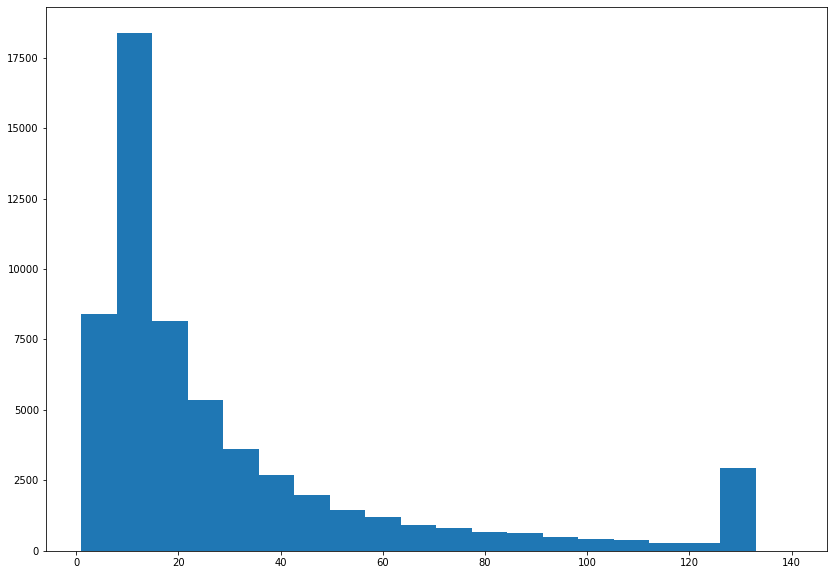

In [30]:
import matplotlib.pyplot as plt

v = df['user_id'].value_counts()

fig = plt.figure(figsize=(14,10))
plt.hist(v,20)
plt.show()

Identify a joke with a rating of 10

In [31]:
df_best = df.loc[df["rating"]==10]
df_best.head()

,user_id,item_id,rating,timestamp
755,17,17,10.0,None
758,17,20,10.0,None
766,17,35,10.0,None
771,17,49,10.0,None
2571,65,8,10.0,None


In [32]:
df_worst = df.loc[df["rating"]==-10]
df_best.head()

,user_id,item_id,rating,timestamp
755,17,17,10.0,None
758,17,20,10.0,None
766,17,35,10.0,None
771,17,49,10.0,None
2571,65,8,10.0,None


In [33]:
df_best['item_id'].unique().shape[0]

133

In [34]:
df['item_id'].unique().shape[0]

140

## Load data again from the reduced dataframe:

In [35]:
from surprise import Reader 
reader = Reader(rating_scale=(-10, 10))
data_small = Dataset.load_from_df(df_small[['user_id', 'item_id', 'rating']], reader)

# Exercise 2: Different ways to fit a recommender systems:

---



---



## a) Training with the whole reduced dataset

First, create a trainable set using the build_full_trainset() method from surpise libraries:

https://surprise.readthedocs.io/en/stable/dataset.html#surprise.dataset.DatasetAutoFolds.build_full_trainset



In [37]:
trainset = data_small.build_full_trainset()

Now fit a SVD model-based recommender algorithm:



In [42]:
from surprise import KNNBasic

rec_knn = KNNBasic()
rec_knn.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


Predict the ranking of a certain item item_id from a certain user user_id

In [43]:
raw_data = data_small.raw_ratings
print(raw_data[10])

('46', '44', 6.75, None)


In [44]:
user_id = str(46)  # raw user id (as in the ratings file). They are **strings**!
item_id = str(44)  # raw item id (as in the ratings file). They are **strings**!
true_ranking = 6.75

pred_svd = rec_knn.predict(user_id, item_id,r_ui=true_ranking,verbose=True)


user: 46         item: 44         r_ui = 6.75   est = 5.71   {'actual_k': 10, 'was_impossible': False}


Evaluate performance using training set:

In [45]:
from surprise import accuracy

testset = trainset.build_testset()
train_pred = rec_knn.test(testset)
accuracy.rmse(train_pred)
accuracy.mae(train_pred)
accuracy.mse(train_pred)

RMSE: 0.8176
MAE:  0.6716
MSE: 0.6684


0.6683908853855879

If we evaluate the performance with the training set we get a very low prediction error since the observations user to construct the model are also used to test it. This is not the normal procedure in machine learning. Instead, 
we split the dataset in training and test subsets. Let's see what happens when applying different propostions for the training and test subsets. 


## b) Split training and test with different proportions:

In [46]:
from surprise.model_selection import train_test_split

print('90% training 10% test:')
trainset, testset = train_test_split(data_small, test_size=.1)
rec_knn.fit(trainset)
train_pred = rec_knn.test(testset)
accuracy.rmse(train_pred)
accuracy.mae(train_pred)
accuracy.mse(train_pred)


90% training 10% test:
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 4.9395
MAE:  3.8972
MSE: 24.3984


24.398386893526943

## c) Cross-validation:

Let's evaluate the performance using a 5-fold cross-validation (cv=5) procedure:


In [47]:
cross_validate(rec_knn, data_small, measures=['RMSE', 'MAE','MSE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE, MSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    4.8372  4.8729  4.8704  5.0282  5.1498  4.9517  0.1192  
MAE (testset)     3.9624  3.9885  3.8417  4.1421  4.1310  4.0131  0.1123  
MSE (testset)     23.3987 23.7452 23.7208 25.2829 26.5207 24.5337 1.1899  
Fit time          0.01    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.01    0.00    0.00    0.00    0.00    0.01    0.00    


{'fit_time': (0.005127429962158203,
  0.0011548995971679688,
  0.0005578994750976562,
  0.0004975795745849609,
  0.00046515464782714844),
 'test_mae': array([3.96242351, 3.98845601, 3.84166482, 4.14206843, 4.13098249]),
 'test_mse': array([23.39874638, 23.74520891, 23.72081062, 25.28288482, 26.52065607]),
 'test_rmse': array([4.83722507, 4.87290559, 4.87040148, 5.02820891, 5.14982097]),
 'test_time': (0.0077397823333740234,
  0.004480123519897461,
  0.00438690185546875,
  0.0043010711669921875,
  0.004441261291503906)}

The average results of the cv procedure indicate that the performance is closer to the one obtained with a train-test split of the 75% - 25%. Note that the cross-validation procedure provides an estimate of the standard deviation of each error score. 